In [11]:
import json
from tqdm import tqdm

In [12]:
import json

input_file = "archive/endomondoHR_proper.json"
output_file = "archive/endomondoHR_fixed.json"

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        corrected_line = line.replace("'", '"')  # Replace single quotes with double quotes
        outfile.write(corrected_line)


In [13]:
import json

input_file = "archive/endomondoHR_fixed.json"

data = []
with open(input_file, "r", encoding="utf-8") as f:
    for line in tqdm(f):
        data.append(json.loads(line))  # Load each line separately

print(f"Loaded {len(data)} JSON objects")


167783it [00:42, 3936.65it/s]

Loaded 167783 JSON objects


In [21]:
print(data[0].keys())

dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed'])


In [22]:
import pandas as pd
# Convert to DataFrame for easier analysis
df = pd.DataFrame(data)

# 1. Count occurrences of each sport
sport_counts = df['sport'].value_counts()
print("Sport Counts:\n", sport_counts)

# 2. Check if longitude, altitude, latitude, timestamp, and heart_rate are the same length for each entry
def check_vector_lengths(row):
    lengths = [len(row[key]) for key in ['longitude', 'altitude', 'latitude', 'timestamp', 'heart_rate']]
    return len(set(lengths)) == 1  # True if all lengths are the same

df['consistent_lengths'] = df.apply(check_vector_lengths, axis=1)

# Count number of inconsistent entries
inconsistent_count = df['consistent_lengths'].value_counts()
print("\nConsistency Check on Vector Lengths:\n", inconsistent_count)

Sport Counts:
 sport
bike                       71915
run                        70591
mountain bike              10722
bike (transport)            7757
indoor cycling              1725
walk                        1289
orienteering                 867
cross-country skiing         789
core stability training      448
fitness walking              292
skate                        271
roller skiing                238
hiking                       237
kayaking                      92
circuit training              89
weight training               74
rowing                        71
gymnastics                    66
soccer                        51
downhill skiing               48
treadmill running             28
snowshoeing                   16
swimming                      14
golf                          12
elliptical                    10
horseback riding              10
badminton                     10
basketball                     8
tennis                         8
aerobics              

In [44]:
pip install webdriver_manager

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/movement-0.0.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [189]:
def plot_route(latitude, longitude, map_filename="route_map.html", image_filename="route_map.png", 
               plt_route=False, image_size=800):
    """
    Plots a route using latitude and longitude lists on a square OpenStreetMap-based interactive map.
    Ensures the entire route is visible in a square viewport and returns the corner coordinates.

    Args:
        latitude (list): List of latitude coordinates.
        longitude (list): List of longitude coordinates.
        map_filename (str): Output filename for the HTML map.
        image_filename (str): Output filename for the map image.
        plt_route (bool): Whether to plot the route line and markers.
        image_size (int): Size in pixels for the square image (width=height).

    Returns:
        tuple: (folium.Map, numpy.ndarray) The generated interactive map and the square bounds as a numpy array.
    """
    import numpy as np
    import folium
    from PIL import Image
    import io
    import base64
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    
    if not latitude or not longitude or len(latitude) != len(longitude):
        raise ValueError("Latitude and longitude lists must be non-empty and of the same length.")

    # Calculate the bounds
    min_lat = min(latitude)
    max_lat = max(latitude)
    min_lon = min(longitude)
    max_lon = max(longitude)
    
    # Calculate the center of the route
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2
    
    # Calculate the range in each dimension
    lat_range = max_lat - min_lat
    lon_range = max_lon - min_lon
        
    # Add padding (smaller value of 5%)
    padding = 0.05
    lat_range = lat_range * (1 + padding)
    lon_range = lon_range * (1 + padding)
    
    # Make it square by using the larger of the two ranges
    # Adjust for the fact that longitude degrees vary in distance based on latitude
    avg_latitude_radians = np.radians(center_lat)
    lon_scale_factor = np.cos(avg_latitude_radians)
    
    # Adjust lon_range to be in "latitude-equivalent" units
    lon_range_scaled = lon_range / lon_scale_factor
    
    # Use the larger of the two ranges to determine the square dimensions
    # But don't make the square too much larger than needed
    max_expansion_factor = 2.0  # Limit how much we expand the smaller dimension
    
    if lat_range > lon_range_scaled:
        # Latitude range is larger
        half_side_lat = lat_range / 2
        # Calculate longitude half-side but limit expansion
        computed_half_side_lon = half_side_lat * lon_scale_factor
        max_half_side_lon = (lon_range / 2) * max_expansion_factor
        half_side_lon = min(computed_half_side_lon, max_half_side_lon)
    else:
        # Longitude range is larger (in lat-equivalent units)
        half_side_lon = lon_range / 2
        # Calculate latitude half-side but limit expansion
        computed_half_side_lat = half_side_lon / lon_scale_factor
        max_half_side_lat = (lat_range / 2) * max_expansion_factor
        half_side_lat = min(computed_half_side_lat, max_half_side_lat)
    
    # Calculate the square bounds
    square_min_lat = center_lat - half_side_lat
    square_max_lat = center_lat + half_side_lat
    square_min_lon = center_lon - half_side_lon
    square_max_lon = center_lon + half_side_lon
    
    # Create square bounds
    sw = [square_min_lat, square_min_lon]
    ne = [square_max_lat, square_max_lon]
    
    # Create a Folium map with a square container
    route_map = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=None,
        tiles="OpenStreetMap",
        width=image_size,
        height=image_size  # Set explicit height=width for square
    )
    
    # Apply bounds to the map
    route_map.fit_bounds([sw, ne])
    
    # Debug information
    print(f"Route boundaries: Lat [{min_lat:.6f}, {max_lat:.6f}], Lon [{min_lon:.6f}, {max_lon:.6f}]")
    print(f"Square boundaries: Lat [{square_min_lat:.6f}, {square_max_lat:.6f}], Lon [{square_min_lon:.6f}, {square_max_lon:.6f}]")
    print(f"Lat range: {lat_range:.6f}, Lon range: {lon_range:.6f} (scaled: {lon_range_scaled:.6f})")
    print(f"Half sides: Lat {half_side_lat:.6f}, Lon {half_side_lon:.6f}")
    
    # Calculate all four corners
    corner_bounds = np.array([
        [square_min_lat, square_min_lon],  
        [square_max_lat, square_max_lon]
    ])

    # Add route to the map
    route = list(zip(latitude, longitude))

    if plt_route:
        folium.PolyLine(route, color="blue", weight=5, opacity=0.7).add_to(route_map)

        # Add start and end markers
        folium.Marker(route[0], popup="Start", icon=folium.Icon(color="green")).add_to(route_map)
        folium.Marker(route[-1], popup="End", icon=folium.Icon(color="red")).add_to(route_map)

    # Save the map as an HTML file
    route_map.save(map_filename)
    print(f"Map saved as {map_filename}. Open it in a browser to view.")
    
    # Method 1: Using built-in _to_png (may not preserve aspect ratio perfectly)
    try:
        img_data = route_map._to_png(delay=5)
        img = Image.open(io.BytesIO(img_data))
        # Ensure the image is square by resizing
        img = img.resize((image_size, image_size))
        img.save(image_filename)
        print(f"Map image saved as {image_filename} using built-in method.")
    except Exception as e:
        print(f"Failed to save image using built-in method: {e}")
        print("Trying alternative method...")
        
        # Method 2: Using Selenium for more control (requires Chrome/Chromium)
        try:
            # Set up Chrome options
            chrome_options = Options()
            chrome_options.add_argument("--headless")
            chrome_options.add_argument("--no-sandbox")
            chrome_options.add_argument("--disable-dev-shm-usage")
            chrome_options.add_argument(f"--window-size={image_size},{image_size}")
            
            # Initialize WebDriver
            driver = webdriver.Chrome(options=chrome_options)
            
            # Open the HTML file
            driver.get(f"file://{os.path.abspath(map_filename)}")
            
            # Wait for the map to load
            import time
            time.sleep(2)
            
            # Take screenshot
            driver.save_screenshot(image_filename)
            print(f"Map image saved as {image_filename} using Selenium.")
            
            # Close the browser
            driver.quit()
        except Exception as selenium_error:
            print(f"Failed to save image using Selenium: {selenium_error}")
            print("Please ensure the map is saved as HTML and view it manually.")

    return route_map, corner_bounds


# Example usage:


In [118]:
import math
def haversine_distance(lat1, lon1, lat2, lon2):
    # calculate distance between 2 points on Earth

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    # Earth's radius in miles
    radius = 3958.8  # miles (6371 km)
    
    # Calculate distance
    distance = radius * c
    
    return distance

def get_route_distance(latitudes, longitudes):
    total_distance = 0
    # Calculate distance between consecutive points
    for i in range(len(latitudes) - 1):
        distance = haversine_distance(
            latitudes[i], longitudes[i],
            latitudes[i+1], longitudes[i+1]
        )
        total_distance += distance
        
    return total_distance


def calculate_route_duration(timestamps):
        
    # Calculate duration in seconds
    start_time = timestamps[0]
    end_time = timestamps[-1]
    duration_seconds = end_time - start_time
    
    # Convert to minutes
    duration_minutes = duration_seconds / 60
    
    return duration_minutes

In [97]:
from tqdm import tqdm
tqdm.pandas()
run_routes = df[df['sport']=='run']

run_routes['distance'] = run_routes.progress_apply(lambda row: get_route_distance(row['latitude'], row['longitude']), axis=1)
run_routes['duration'] = run_routes.progress_apply(lambda row: calculate_route_duration(row['timestamp']), axis=1)
run_routes.head()

100%|██████████| 70591/70591 [00:15<00:00, 4542.32it/s]
/var/folders/d4/c154mt9s11x5q965j91l06qw0000gn/T/ipykernel_90687/336132092.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_routes['distance'] = run_routes.progress_apply(lambda row: get_route_distance(row['latitude'], row['longitude']), axis=1)
100%|██████████| 70591/70591 [00:00<00:00, 352835.04it/s]
/var/folders/d4/c154mt9s11x5q965j91l06qw0000gn/T/ipykernel_90687/336132092.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_routes['durati

,longitude,altitude,latitude,sport,id,heart_rate,gender,timestamp,url,userId,speed,consistent_lengths,distance,duration
29,"[6.8854929, 6.8853678, 6.8851621, 6.8848205, 6...","[-173.8, -151.2, -161.6, -165.4, -168.6, -172....","[52.2226809, 52.222727, 52.2228258, 52.2228606...",run,321063199,"[80, 81, 94, 100, 102, 112, 108, 114, 110, 109...",male,"[1397079203, 1397079210, 1397079218, 139707922...",https://www.endomondo.com/users/4969375/workou...,4969375,NaN,True,5.361321,64.800000
30,"[6.9144073, 6.9142929, 6.9141539, 6.9140268, 6...","[57.8, 57.6, 57.0, 56.4, 55.8, 55.2, 54.4, 53....","[52.2111711, 52.2112631, 52.2114064, 52.211608...",run,303565793,"[60, 62, 92, 92, 132, 150, 150, 159, 159, 161,...",male,"[1393908533, 1393908541, 1393908549, 139390855...",https://www.endomondo.com/users/4969375/workou...,4969375,NaN,True,8.844797,70.066667
31,"[6.9141348, 6.9145702, 6.9151684, 6.9158377, 6...","[22.8, 26.4, 30.8, 35.6, 43.0, 48.4, 49.8, 49....","[52.2110297, 52.2106325, 52.2102453, 52.209833...",run,302666522,"[77, 93, 107, 121, 118, 120, 120, 124, 124, 12...",male,"[1393687929, 1393687948, 1393687967, 139368798...",https://www.endomondo.com/users/4969375/workou...,4969375,NaN,True,18.246353,168.766667
32,"[6.8678543, 6.8678634, 6.8675429, 6.8672183, 6...","[35.4, 35.2, 34.6, 34.2, 35.0, 35.2, 34.8, 34....","[52.1936673, 52.1934354, 52.1931993, 52.192873...",run,296982347,"[75, 101, 116, 120, 124, 126, 127, 129, 126, 1...",male,"[1392480163, 1392480176, 1392480189, 139248020...",https://www.endomondo.com/users/4969375/workou...,4969375,NaN,True,13.584195,108.383333
33,"[6.9143328, 6.9146396, 6.9148949, 6.9151568, 6...","[63.0, 65.2, 66.0, 66.2, 65.8, 65.8, 67.0, 67....","[52.2112195, 52.2110264, 52.2108135, 52.210601...",run,295890426,"[58, 83, 112, 115, 117, 116, 141, 121, 120, 11...",male,"[1392180426, 1392180436, 1392180446, 139218045...",https://www.endomondo.com/users/4969375/workou...,4969375,NaN,True,10.438034,85.300000


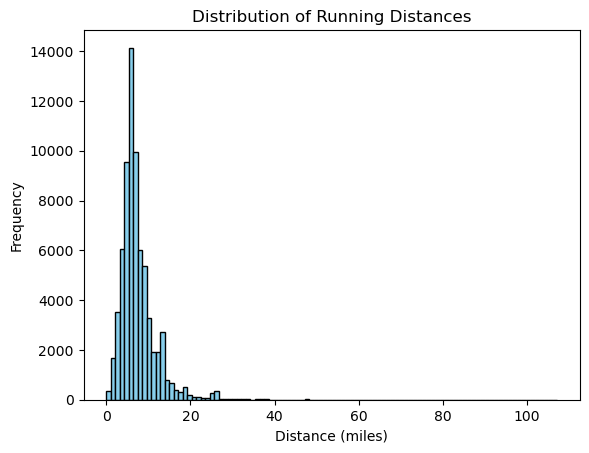

In [98]:
import matplotlib.pyplot as plt

plt.hist(run_routes['distance'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.title('Distribution of Running Distances')
plt.show()

There are 66 runs with distance less than 0.1 miles
There are 335 runs with distance greater than 26.2 miles


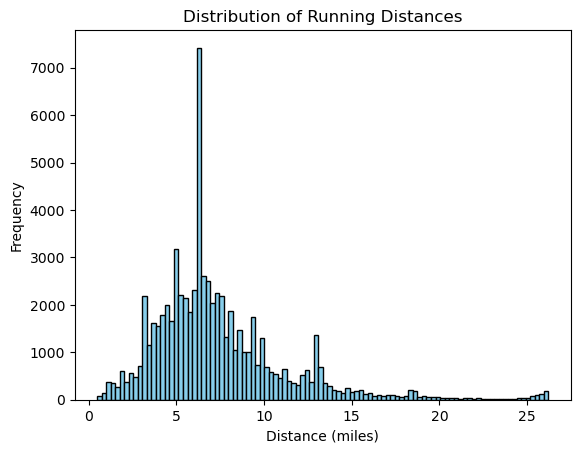

In [99]:
print(f'There are {len(run_routes[run_routes["distance"] < 0.5])} runs with distance less than 0.1 miles')
print(f'There are {len(run_routes[run_routes["distance"] > 26.2])} runs with distance greater than 26.2 miles')

run_routes = run_routes[(run_routes['distance'] >= 0.5) & (run_routes['distance'] <= 26.2)]
plt.hist(run_routes['distance'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.title('Distribution of Running Distances')
plt.show()

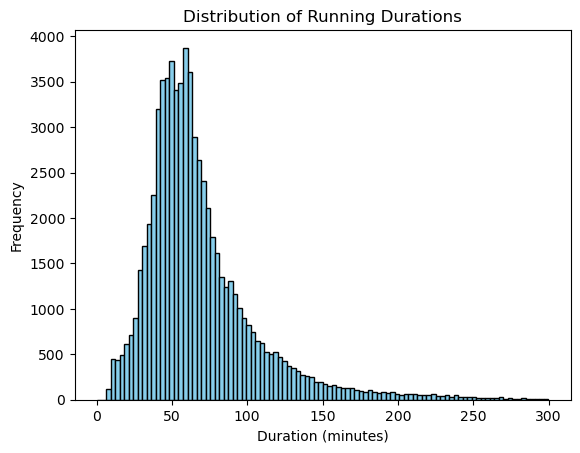

In [100]:
plt.hist(run_routes['duration'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Running Durations')
plt.show()

There are 1 runs with duration less than 5 minutes
There are 1589 runs with duration greater than 180 minutes


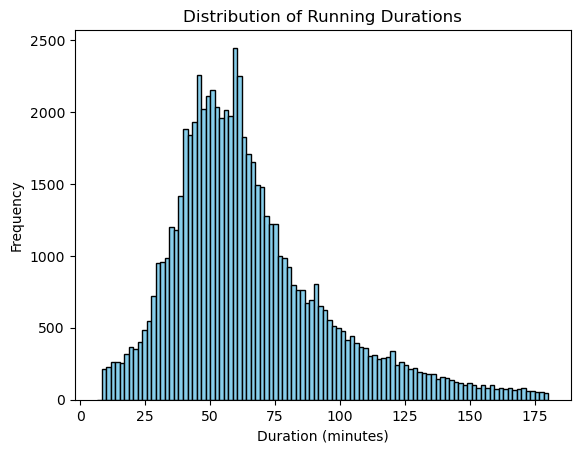

In [103]:
print(f'There are {len(run_routes[run_routes["duration"] < 5])} runs with duration less than 5 minutes')
print(f'There are {len(run_routes[run_routes["duration"] > 180])} runs with duration greater than 180 minutes')

run_routes = run_routes[(run_routes['duration'] >= 5) & (run_routes['duration'] <= 180)]
plt.hist(run_routes['duration'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Running Durations')
plt.show()

In [192]:
import numpy as np
test = np.random.randint(0, len(run_routes), 1)[0]

latitude = df.loc[test,'latitude']  
longitude = df.loc[test,'longitude'] 

# Generate the route map
map_object, bounds = plot_route(latitude, longitude, plt_route=True)

# Display the map (Jupyter Notebook only)
print(bounds)
map_object


Route boundaries: Lat [58.539757, 58.673325], Lon [5.596233, 5.744652]
Square boundaries: Lat [58.466295, 58.746787], Lon [5.592523, 5.748362]
Lat range: 0.140246, Lon range: 0.155840 (scaled: 0.299167)
Half sides: Lat 0.140246, Lon 0.077920
Map saved as route_map.html. Open it in a browser to view.
Map image saved as route_map.png using built-in method.
[[58.4662946   5.59252252]
 [58.7467874   5.74836248]]


In [123]:
map_object.get_bounds()

[[None, None], [None, None]]

In [194]:
def geo_to_pixel(lat, lon, bounds, image_width, image_height):
    """
    Convert geographic coordinates (latitude, longitude) to pixel coordinates on the map image.
    
    Args:
        lat (float): Latitude coordinate.
        lon (float): Longitude coordinate.
        bounds (numpy.ndarray): 2x2 array with [[min_lat, min_lon], [max_lat, max_lon]]
        image_width (int): Width of the saved image in pixels.
        image_height (int): Height of the saved image in pixels.
        
    Returns:
        tuple: (x, y) pixel coordinates on the image.
    """
    # Extract bounds information
    min_lat, min_lon = bounds[0]  # south, west
    max_lat, max_lon = bounds[1]  # north, east
    
    # Calculate the proportion of the point within the bounds
    x_prop = (lon - min_lon) / (max_lon - min_lon)
    # Flip the y-coordinate because latitude increases as we go up the image
    y_prop = 1 - (lat - min_lat) / (max_lat - min_lat)
    
    # Convert to pixel coordinates
    x_pixel = int(x_prop * image_width)
    y_pixel = int(y_prop * image_height)
    
    return (x_pixel, y_pixel)


def pixel_to_geo(x, y, bounds, image_width, image_height):
    """
    Convert pixel coordinates to geographic coordinates (latitude, longitude).
    
    Args:
        x (int): X-coordinate on the image.
        y (int): Y-coordinate on the image.
        bounds (numpy.ndarray): 2x2 array with [[min_lat, min_lon], [max_lat, max_lon]]
        image_width (int): Width of the saved image in pixels.
        image_height (int): Height of the saved image in pixels.
        
    Returns:
        tuple: (latitude, longitude) geographic coordinates.
    """
    # Extract bounds information
    min_lat, min_lon = bounds[0]  # south, west
    max_lat, max_lon = bounds[1]  # north, east
    
    # Calculate proportions
    x_prop = x / image_width
    # Flip the y-coordinate because latitude increases as we go up the image
    y_prop = 1 - (y / image_height)
    
    # Convert to geographic coordinates
    lon = min_lon + x_prop * (max_lon - min_lon)
    lat = min_lat + y_prop * (max_lat - min_lat)
    
    return (lat, lon)


def demonstrate_conversion(latitude, longitude, map_filename="route_map.html"):
    """
    Demonstrates the conversion between geographic coordinates and pixel coordinates.
    
    Args:
        latitude (list): List of latitude coordinates.
        longitude (list): List of longitude coordinates.
        map_filename (str): Output filename for the HTML map.
    """
    from PIL import Image, ImageDraw
    import os
    
    # First, create and save the map
    route_map, bounds = plot_route(latitude, longitude, map_filename, "route_map.png", plt_route=True)
    
    # Get the image dimensions
    image_width, image_height = get_image_dimensions("route_map.png")
    
    # Create a copy of the image to draw on
    img = Image.open("route_map.png")
    draw = ImageDraw.Draw(img)
    
    # Convert each point in the route to pixel coordinates and mark them
    for lat, lon in zip(latitude, longitude):
        # Debug print
        print(f"Processing point: lat={lat}, lon={lon}")
        print(f"Using bounds: {bounds}")
        
        x, y = geo_to_pixel(lat, lon, bounds, image_width, image_height)
        lat_check, lon_check = pixel_to_geo(x, y, bounds, image_width, image_height)

        print(f"Original geo: ({lat:.6f}, {lon:.6f})")
        print(f"Converted pixel: ({x}, {y})")
        print(f"Back to geo: ({lat_check:.6f}, {lon_check:.6f})")
        print(f"lat/lon difference: {lat-lat_check:.6f}, {lon-lon_check:.6f}")

        # Draw a red dot with black outline
        draw.ellipse((x-3, y-3, x+3, y+3), fill='red', outline='black')
    
    # Save the marked image
    marked_filename = "marked_route_map.png"
    img.save(marked_filename)
    print(f"Marked map saved as {marked_filename}")
    
    # Test reverse conversion with a few points on the image
    test_points = [
        (50, 50),  # Top-left area
        (image_width // 2, image_height // 2),  # Center
        (image_width - 50, image_height - 50)  # Bottom-right area
    ]
    
    print("\nTesting reverse conversion with sample points:")
    for x, y in test_points:
        lat, lon = pixel_to_geo(x, y, bounds, image_width, image_height)
        x_check, y_check = geo_to_pixel(lat, lon, bounds, image_width, image_height)
        
        print(f"Original pixel: ({x}, {y})")
        print(f"Converted geo: ({lat:.6f}, {lon:.6f})")
        print(f"Back to pixel: ({x_check}, {y_check})")
        print(f"Difference: ({x - x_check}, {y - y_check})")
        print("-" * 30)

In [197]:
test = np.random.randint(0, len(run_routes))

latitude = df.loc[test,'latitude']  
longitude = df.loc[test,'longitude'] 

demonstrate_conversion(latitude, longitude)

Route boundaries: Lat [53.394545, 53.458176], Lon [-2.438526, -2.297375]
Square boundaries: Lat [53.359549, 53.493173], Lon [-2.442054, -2.293846]
Lat range: 0.066812, Lon range: 0.148208 (scaled: 0.248732)
Half sides: Lat 0.066812, Lon 0.074104
Map saved as route_map.html. Open it in a browser to view.
Map image saved as route_map.png using built-in method.
Processing point: lat=53.42702966183424, lon=-2.314034840092063
Using bounds: [[53.35954859 -2.4420544 ]
 [53.49317256 -2.29384629]]
Original geo: (53.427030, -2.314035)
Converted pixel: (691, 395)
Back to geo: (53.427196, -2.314040)
lat/lon difference: -0.000166, 0.000005
Processing point: lat=53.42691441066563, lon=-2.3139144759625196
Using bounds: [[53.35954859 -2.4420544 ]
 [53.49317256 -2.29384629]]
Original geo: (53.426914, -2.313914)
Converted pixel: (691, 396)
Back to geo: (53.427029, -2.314040)
lat/lon difference: -0.000114, 0.000125
Processing point: lat=53.426684495061636, lon=-2.3137407191097736
Using bounds: [[53.35954